In this code note, I will present some time series techniques applied on activities sequences of human/bot users to predict number of activities to efficiently use Github api.

# Packages importing & visualisation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

In [3]:
activities = pd.read_parquet('../data-raw/activities.parquet')

In [4]:
activities_by_day = (
    activities
    .assign(date=pd.to_datetime(activities['date']).dt.date)
    # Grouping data by contributor and date, and counting up the activities by day
    .groupby(['contributor', 'date'])
    .activity
    .count()
    .reset_index(name='n_activities')
)
activities_by_day

,contributor,date,n_activities
0,0crat,2022-11-25,42
1,0crat,2022-11-26,3
2,0crat,2022-11-28,22
3,0crat,2022-11-29,44
4,0crat,2022-11-30,38
...,...,...,...
53348,zorro-bot[bot],2023-04-07,1
53349,zorro-bot[bot],2023-04-11,1
53350,zorro-bot[bot],2023-04-12,2
53351,zorro-bot[bot],2023-04-13,2


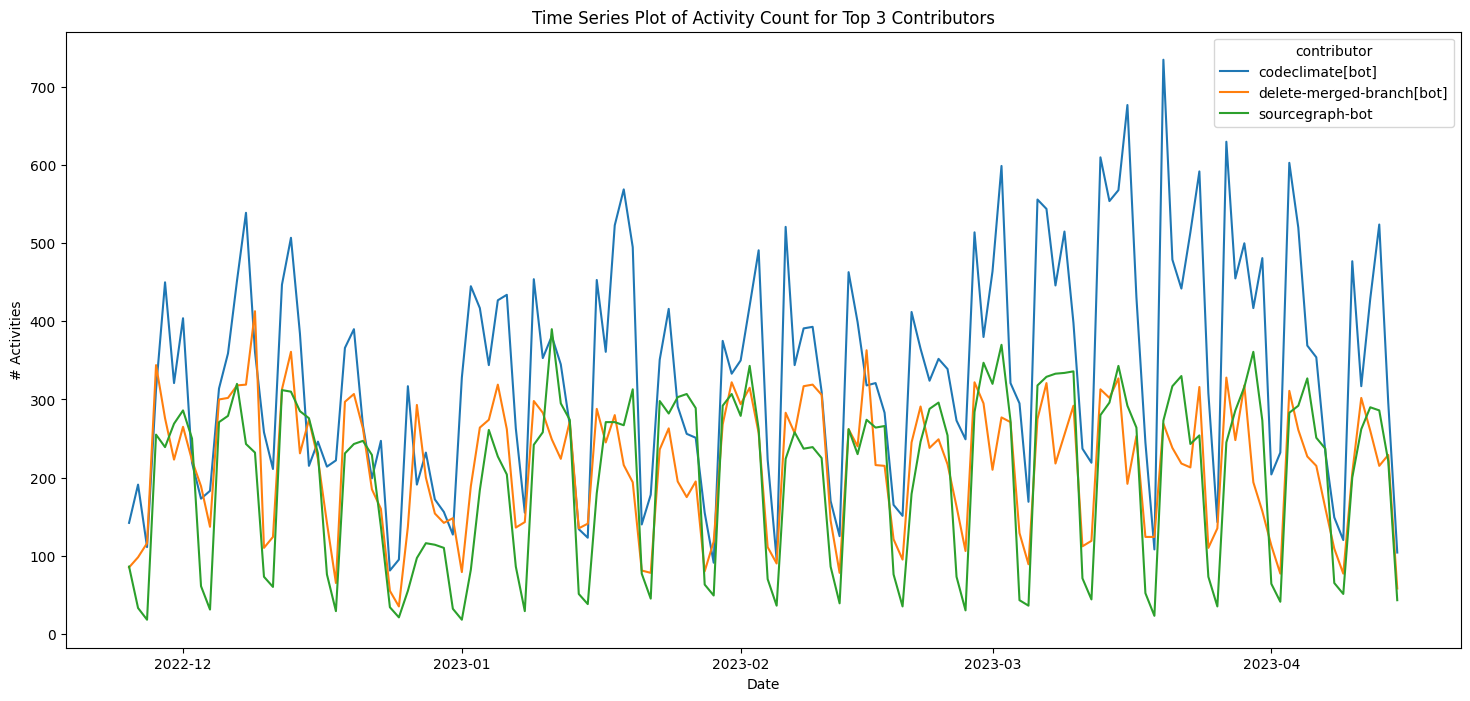

In [5]:
temp = (
    activities_by_day[
        activities_by_day['contributor']
        .isin(activities_by_day
              .groupby('contributor')['n_activities']
              .median()
              .nlargest(3)
              .index
            )
    ]
)

# Plotting the time series
plt.figure(figsize=(18, 8))
sns.lineplot(x='date', y='n_activities', hue='contributor', data=temp)
plt.title('Time Series Plot of Activity Count for Top 3 Contributors')
plt.xlabel('Date')
plt.ylabel('# Activities')
plt.show()


# Multiple linear regression model

In [6]:
# Get the data of the top contributor 'codeclimate[bot]' to test time series forcasting method
temp = (
    activities_by_day[activities_by_day['contributor'] == 'codeclimate[bot]']
    .drop(['contributor'], axis=1)
    .reset_index(drop=True)
)

# Feature Engineering: create lag features based on the n previous dates
n_previous_dates = 13
for i in range(1, n_previous_dates+1):
    temp[f'n_activities_lag_{i}'] = temp['n_activities'].shift(i)

# Delete the n first rows to avoid NaN values
temp = temp.iloc[n_previous_dates:].reset_index(drop=True)

In [7]:
# Split the data into training and test sets (last 20% of the data)
train_size = int(len(temp) * 0.8)
train_data, test_data = temp[:train_size], temp[train_size:]

# Separate features and target variable for training
X_train = train_data.drop(['date', 'n_activities'], axis=1)
y_train = train_data['n_activities']

# Separate features and target variable for testing
X_test = test_data.drop(['date', 'n_activities'], axis=1)
y_test = test_data['n_activities']

# Train the time series forecasting model with multiple linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

In [8]:
# Calculate Mean Squared Error
print(f'R2 Score: {r2_score(y_test, predictions)}')
print(f'Explained variance score: {explained_variance_score(y_test, predictions)}')

R2 Score: 0.655215420552469
Explained variance score: 0.6552736527765557


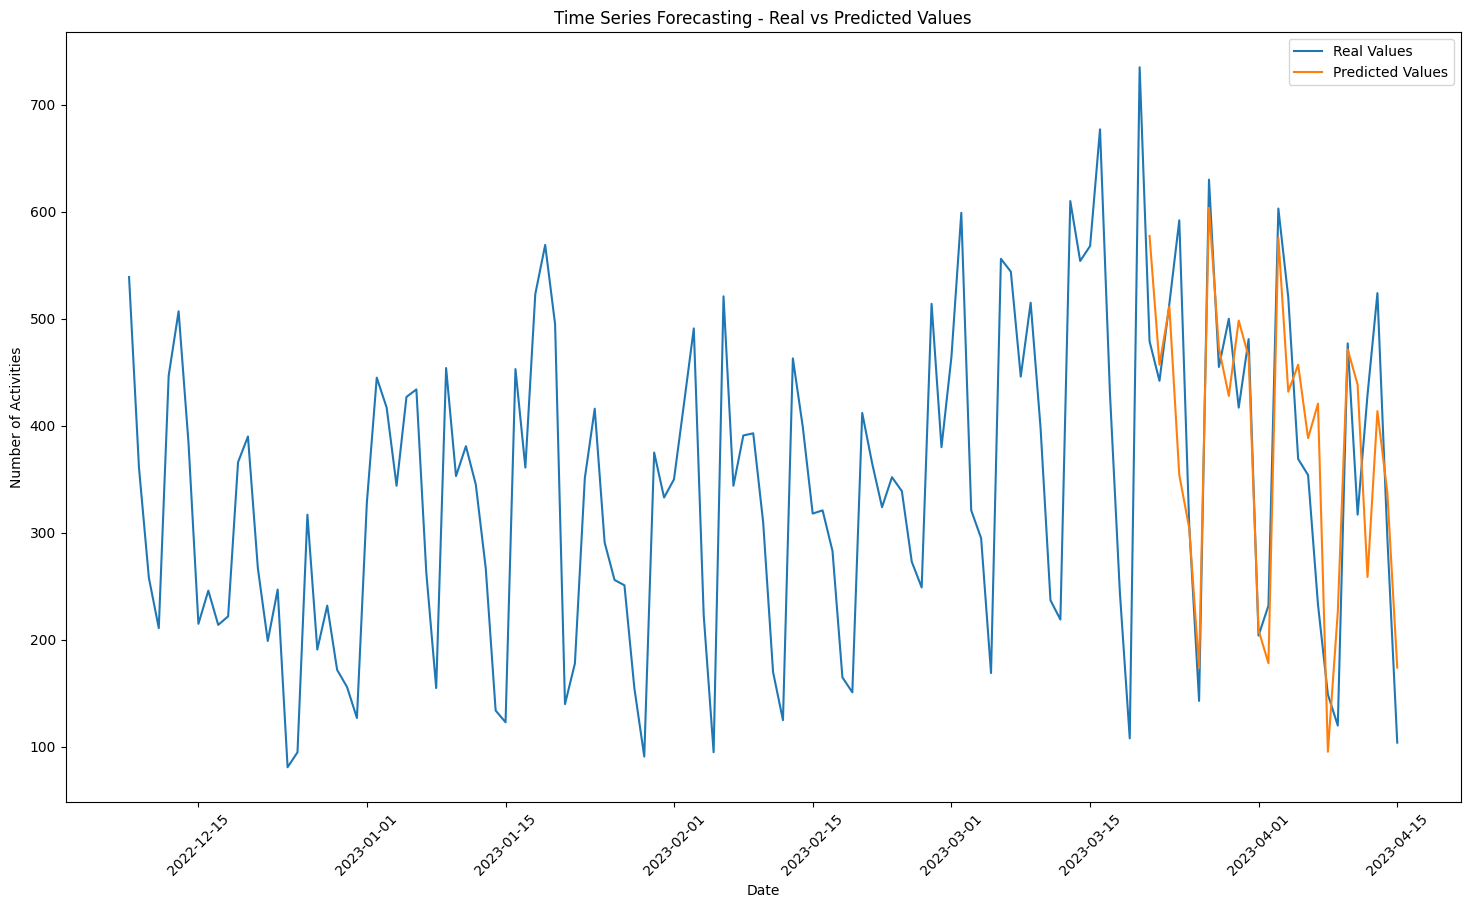

In [9]:
# Visualize Results
plt.figure(figsize=(18, 10))
sns.lineplot(x=temp['date'], y=temp['n_activities'], label='Real Values')
sns.lineplot(x=test_data['date'], y=predictions, label='Predicted Values')
plt.title('Time Series Forecasting - Real vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Number of Activities')
plt.xticks(rotation=45)
plt.legend()
plt.show()